<a href="https://colab.research.google.com/github/Ishmeet7/Sentiment_Analysis/blob/main/imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Importing libraries**

In [ ]:
!pip install contractions

In [ ]:
import pandas as pd  #for importing data and data pre processing
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re             #for regex functions
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import contractions
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')


###**Loading data**

In [ ]:
df=pd.read_csv(r"/content/drive/MyDrive/IMDB Dataset.csv")  #reading data from csv

###**Exploratory data analysis**

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df['review'].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
df.shape

(50000, 2)

In [ ]:
df['review'].isna().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
#checking what percentage of reviews are positive  and negative
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
df.drop_duplicates(subset='review',inplace=True)  #dropping duplicate reviews

df.shape

(49582, 2)

Text(0.5, 1.0, 'Sentiment distribution')

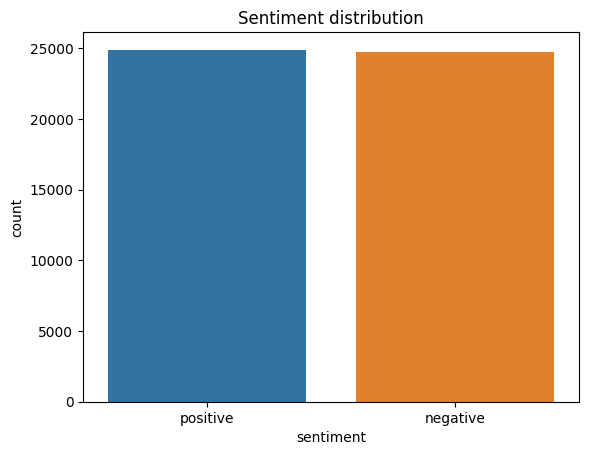

In [ ]:
sns.countplot(x='sentiment',data=df)
plt.title('Sentiment distribution')

In [ ]:
df.sentiment.value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

No. of negative reviews become less than no of positive reviews after removing duplicates

In [ ]:
def count_words(text): #counting words in each review
  words=text.split()
  word_count=len(words)
  return word_count


In [ ]:
df['word_count']=df['review'].apply(count_words)

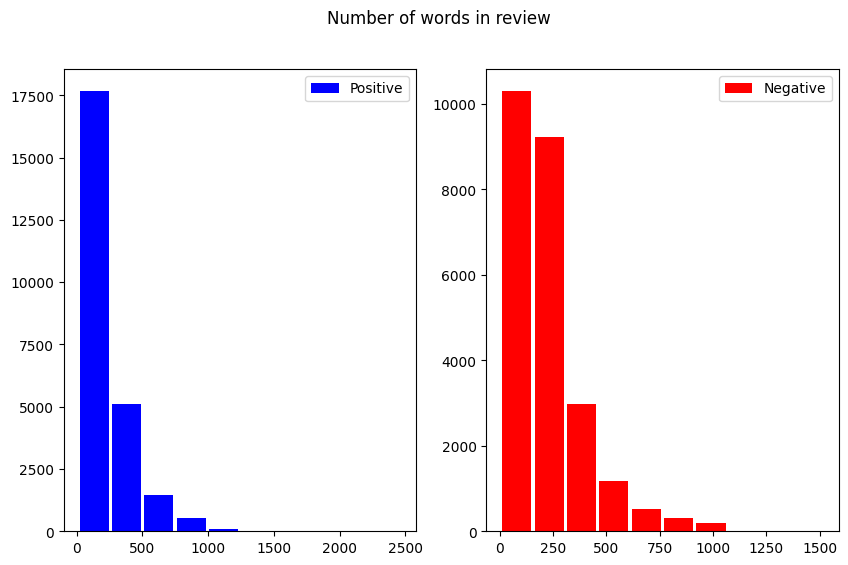

In [ ]:

  fig, ax = plt.subplots(1,2, figsize=(10,6))
  ax[0].hist(df[df['sentiment'] == 'positive']['word_count'], label='Positive', color='blue', rwidth=0.9);
  ax[0].legend(loc='upper right');
  ax[1].hist(df[df['sentiment'] == 'negative']['word_count'], label='Negative', color='red', rwidth=0.9);
  ax[1].legend(loc='upper right');
  fig.suptitle("Number of words in review")
  plt.show()

We can clearly observe that negative reviews contain more words.

###**Cleaning data**
Steps:

1.Converting text to lowercase-to improve feature extraction and reduce dimension

2.Removing HTML tags-came because of scraping

3.Removing special characters and punctuations-to reduce noise

4.Expanding contraction so that they are treated same.

5.removing stop words--do not contribute to sentiment analysis

6.Finally tokenization to do analysis at word level and stemming to reduce word to its root form



In [ ]:

def preprocess(text):
    text=text.lower() #converting text to lower case

    text = BeautifulSoup(text, 'html.parser').get_text() # Remove HTML tags

    text = re.sub('[^a-zA-Z0-9\s]', '', text)  # Remove special characters

    if True:                                   # Expand contractions
        expanded_words = []
        for word in text.split():
        # using contractions.fix to expand the shortened words
          expanded_words.append(contractions.fix(word))

        text = ' '.join(expanded_words)

    text=text.translate(str.maketrans('','',string.punctuation))  #removing punctuations


    # Tokenize the text
    tokens = word_tokenize(text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    #tokens = [textblob.TextBlob(token).correct() for token in tokens]

    # Stem the tokens
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    #clean_text = " ".join(stemmed_tokens)
    clean_text = " ".join([str(token) for token in stemmed_tokens])

    return clean_text

In [ ]:
df['review']=df['review'].apply(preprocess)

In [ ]:
df['review'].shape

(49582,)

In [ ]:
df.drop_duplicates(subset='review',inplace=True)

In [ ]:
df.head(5)

,review,sentiment,word_count
0,one review mention watch 1 oz episod hook righ...,positive,307
1,wonder littl product film techniqu unassum old...,positive,162
2,thought wonder way spend time hot summer weeke...,positive,166
3,basic famili littl boy jake think zombi closet...,negative,138
4,petter mattei love time money visual stun film...,positive,230


Create *word cloud*

In [ ]:
def word_cloud(i):
    df1=df[df.sentiment==i]
    text = ' '.join([word for word in df1['review'] ])
    plt.figure(figsize=(20,15), facecolor='None')
    wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most frequent words in ' +i +' reviews')
    plt.show()

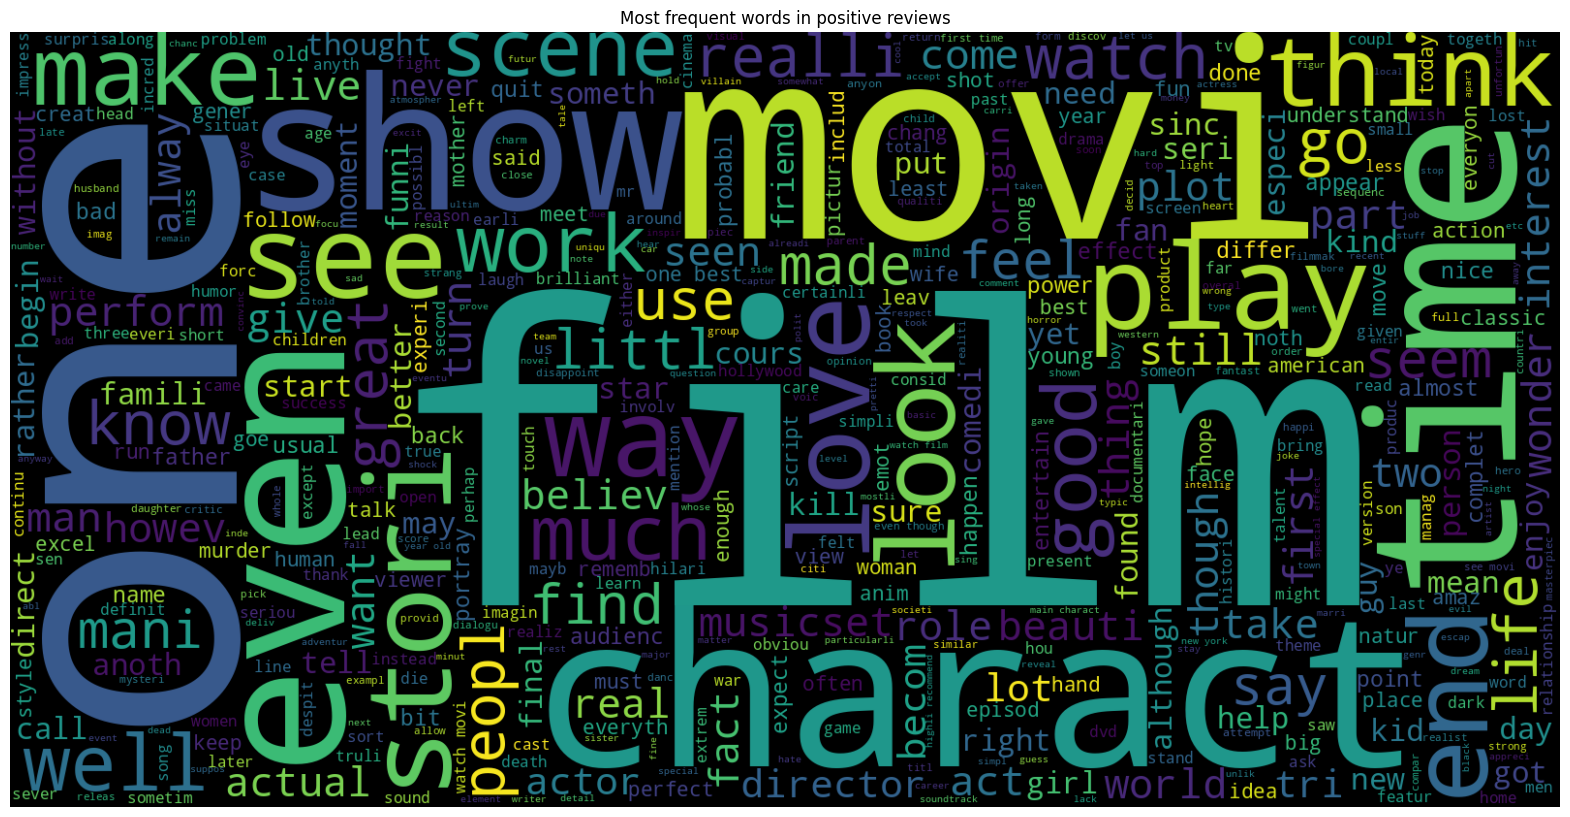

In [ ]:
word_cloud('positive')

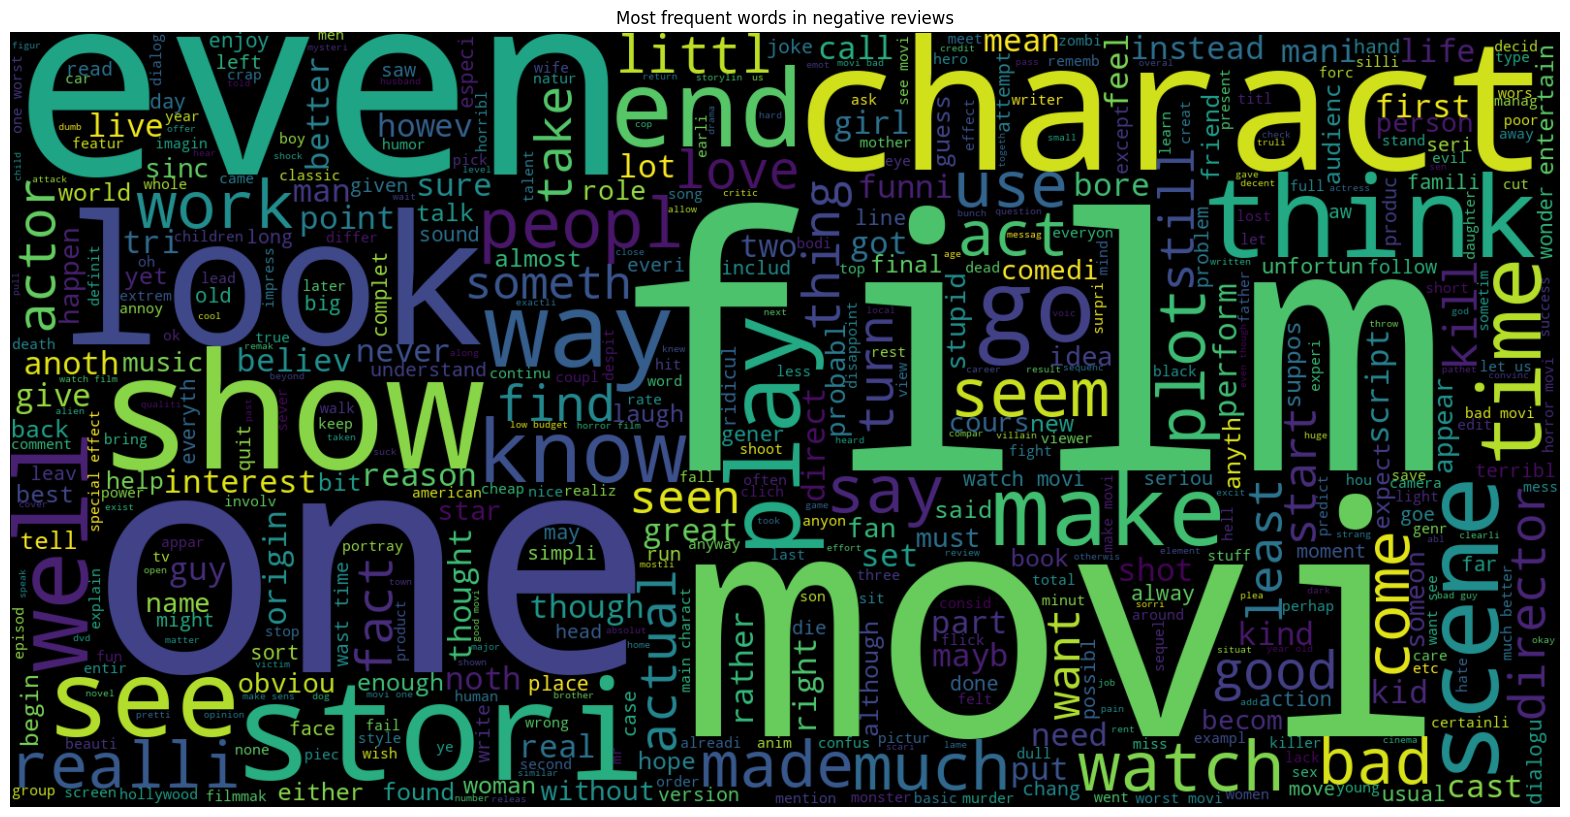

In [ ]:
word_cloud('negative')

###**Model training**

Feature extraction (Vectorize text)

In [ ]:
# Create a bag-of-words model

vectorizer = CountVectorizer()

vectorized = vectorizer.fit_transform(df['review'])

Split into train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vectorized, df['sentiment'], test_size=0.2)


In [ ]:
print("Size of x_train: ", (X_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (X_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (39661, 181466)
Size of y_train:  (39661,)
Size of x_test:  (9916, 181466)
Size of y_test:  (9916,)


Logistic regression

In [ ]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy:",(logreg_acc))
print('confusion matrix:\n',confusion_matrix(y_test, logreg_pred))

Test accuracy: 0.8788826139572409
confusion matrix:
 [[4302  643]
 [ 558 4413]]


Naive Bayes Classifier

In [ ]:

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predict the sentiment of the test reviews
y_pred = classifier.predict(X_test)
mnb_acc = accuracy_score(y_pred, y_test)
# Evaluate the performance of the classifier
# accuracy = np.mean(y_pred == y_test)
print("Test Accuracy:", mnb_acc)
print('confusion matrix:\n',confusion_matrix(y_test, y_pred))

Test Accuracy: 0.8559903186768858
confusion matrix:
 [[4312  633]
 [ 795 4176]]


Random Forest

In [ ]:

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Predict the sentiment of the test reviews
y_pred = classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = np.mean(y_pred == y_test)
print(" Test Accuracy:", accuracy)
print('confusion matrix:\n',confusion_matrix(y_test, y_pred))

 Test Accuracy: 0.8486284792254941
confusion matrix:
 [[4140  805]
 [ 696 4275]]


As per accuracy and confusion matrix we got best results for logistic regression model

**Future Improvement Scopes**

Spelling correction step in pre processing-since sentiment can be associated with specific words.

For feature extraction using pre trained model such as BERT or Word2Vec would have improved accuracy-Word embeddings capture the semantic meaning and relationships between words so sentiment analysis would have been better

Hyperparamater Tuning for models

Using SVM for classification-works wells with high dimensional data



